<a href="https://colab.research.google.com/github/MahmoudMagdy404/Pneumonia-Diagnosis-with-CNN-Transfer-Learning/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

##Import Data & Visualization

#Add the api token (kaggle.json) manually to the directory and run the next cell

In [21]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [22]:

from kaggle.api.kaggle_api_extended import KaggleApi

# Instantiate the Kaggle API
kaggle = KaggleApi()

# Authenticate with the Kaggle API using your API key
kaggle.authenticate()

# Replace 'dataset/username/dataset-name' with the actual dataset path
dataset_path ='paultimothymooney/chest-xray-pneumonia'

# Download the dataset directly to the current working directory
kaggle.dataset_download_files(dataset_path, unzip=True)

In [24]:
os.listdir("/content/chest_xray")

['test', 'train', 'val', '__MACOSX', 'chest_xray']

In [25]:
len(os.listdir("/content/chest_xray/train/PNEUMONIA"))

3875

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


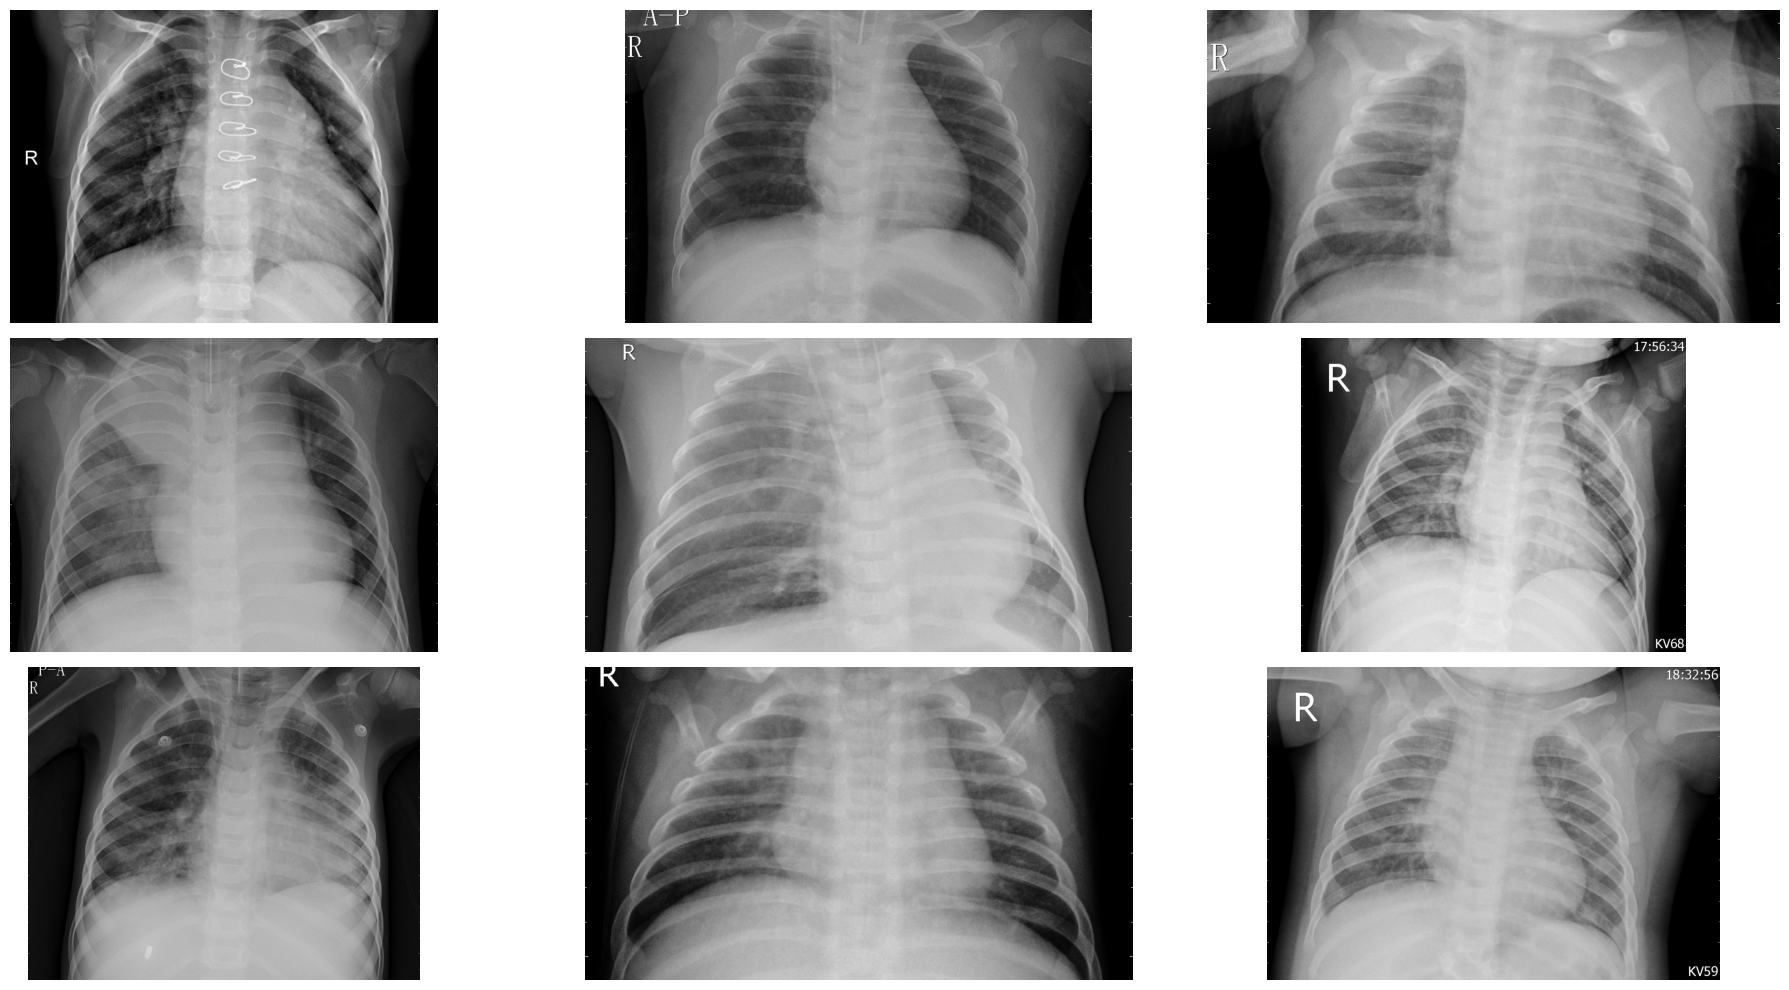

In [26]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("/content/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [48]:
#search for image in the followed Notebook

# my_image = None
# normal_dir = "/content/chest_xray/train/NORMAL"
# for img in os.listdir("/content/chest_xray/train/NORMAL"):
#   img = plt.imread(os.path.join(normal_dir, img))
#   if (img.shape[0]==1128 and img.shape[1]==1336):
#     my_image = img
#   else:
#     my_image = None


The dimensions of the image are 2540 pixels width and 2428 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 163.9797 and the standard deviation is 67.5380


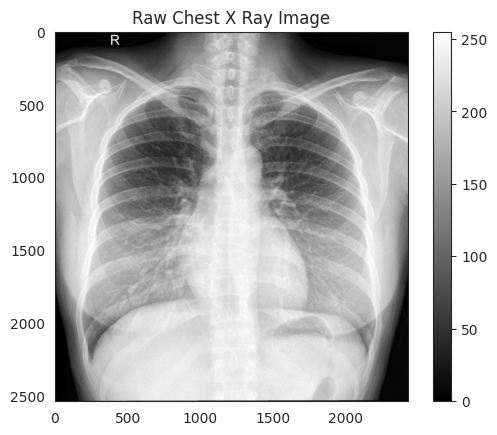

In [60]:
normal_img = os.listdir("/content/chest_xray/train/NORMAL")[0]
normal_dir = "/content/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

<ipython-input-56-d45ac08d2db9>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_img.ravel(),


Text(0, 0.5, '# Pixels in Image')

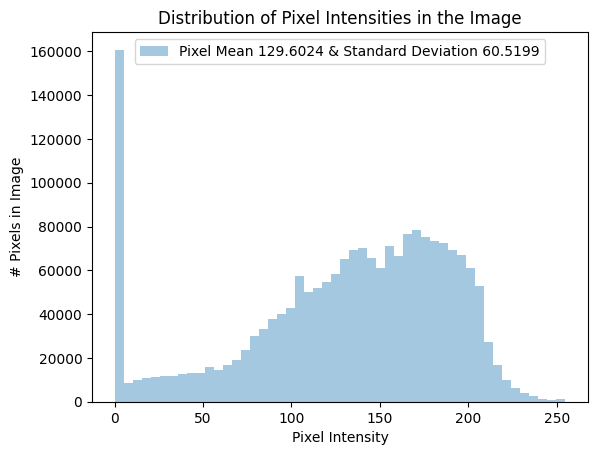

In [56]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

#2. Image Preprocessing



*   Data Augmentation


---



---




In [85]:

def image_gen(activation,train_dir,test_dir,val_dir):
  if activation =='aug':
    image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True)
  else:
    image_generator = ImageDataGenerator()


  train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180, 180))


  test = image_generator.flow_from_directory(test_dir,
                                              batch_size=1,
                                              shuffle=False,
                                              class_mode='binary',
                                              target_size=(180, 180))
  val = image_generator.flow_from_directory(val_dir,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode='binary',
                                                  target_size=(180, 180))
  return (train , test , val)


In [86]:
train,test,val = image_gen('aug',train_dir = "/content/chest_xray/train",
    test_dir = "/content/chest_xray/test",
    val_dir = "/content/chest_xray/val"
    )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.7617 and the minimum is -2.4988
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


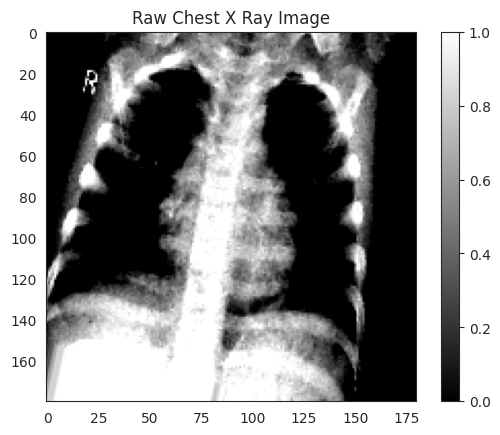

In [87]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

<ipython-input-88-3361fab08a7d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image.ravel(),


Text(0, 0.5, '# Pixels in Image')

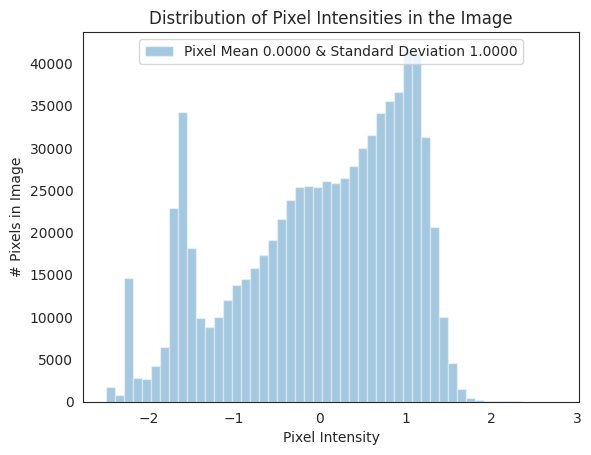

In [88]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')



*  Building a CNN model




In [89]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [90]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [91]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_7 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                      

##Fit the model on the Augmented data

In [93]:
def model_train(model,train_data,validation):
  r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)
  plt.figure(figsize=(12, 8))

  plt.subplot(2, 2, 1)
  plt.plot(r.history['loss'], label='Loss')
  plt.plot(r.history['val_loss'], label='Val_Loss')
  plt.legend()
  plt.title('Loss Evolution')

  plt.subplot(2, 2, 2)
  plt.plot(r.history['accuracy'], label='Accuracy')
  plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
  plt.legend()
  plt.title('Accuracy Evolution')

  return r

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.8050

100/100 [==============================] - 209s 2s/step - loss: 0.5863 - accuracy: 0.8050 - val_loss: 7.6417 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 173s 2s/step - loss: 0.2014 - accuracy: 0.8600
Epoch 3/10
100/100 [==============================] - 168s 2s/step - loss: 0.1860 - accuracy: 0.8462
Epoch 4/10
100/100 [==============================] - 169s 2s/step - loss: 0.1041 - accuracy: 0.8900
Epoch 5/10
100/100 [==============================] - 176s 2s/step - loss: 0.1145 - accuracy: 0.8963
Epoch 6/10
100/100 [==============================] - 169s 2s/step - loss: 0.1581 - accuracy: 0.8687
Epoch 7/10
100/100 [==============================] - 169s 2s/step - loss: 0.1426 - accuracy: 0.8675
Epoch 8/10
100/100 [==============================] - 170s 2s/step - loss: 0.0769 - accuracy: 0.9275
Epoch 9/10
100/100 [==============================] - 171s 2s/step - loss: 0.1537 - accuracy: 0.8600
Epoch 10/10
100/100 [==============================] - 169s 

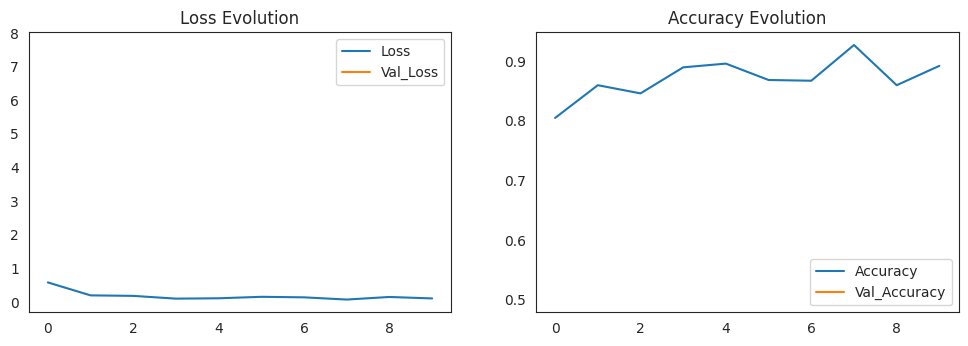

In [94]:
r = model_train(model,train,val)

In [99]:
def model_eval(model,test_data):
  evaluation = model.evaluate(test)
  print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

  evaluation = model.evaluate(train)
  print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

  pred = model.predict(test)

  print(confusion_matrix(test.classes, pred > 0.5))
  report = pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))
  return report

In [100]:
report = model_eval(model,test)

624/624 [==============================] - 48s 77ms/step - loss: 0.6767 - accuracy: 0.7933
Test Accuracy: 79.33%
652/652 [==============================] - 319s 490ms/step - loss: 0.1801 - accuracy: 0.9371
Train Accuracy: 93.71%
624/624 [==============================] - 43s 69ms/step
[[136  98]
 [ 12 378]]


##Fit the model on the non Augmented data

In [103]:
train_no,test_no,val_no = image_gen('no_aug',train_dir = "/content/chest_xray/train",
    test_dir = "/content/chest_xray/test",
    val_dir = "/content/chest_xray/val"
    )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [104]:
r = model_train(model,train_no,val_no)

Epoch 1/10
 13/100 [==>...........................] - ETA: 2:42 - loss: 0.4055 - accuracy: 0.8654

KeyboardInterrupt: ignored